In [8]:
from xgboost import XGBClassifier
import xgboost as xgb
import shap
import seaborn as sns
import scipy
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean,std
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold, StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score,accuracy_score,average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score,balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.patches import ConnectionPatch
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import  roc_curve, RocCurveDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_recall_curve

In [2]:
df=pd.read_csv('data/df.csv',index_col=0)

In [3]:
X=df.iloc[:,:-1]
y=[]
for i in df.index:
    if df.loc[i,'Diagnosis']=='Normal':
        y.append(0)
    else:
        y.append(1)
y=np.array(y)

In [4]:
np.random.seed(1) # Reproducibility 
CV_repeats = 20
# Make a list of random integers between 0 and 10000 of length = CV_repeats to act as different data splits
random_states = np.random.randint(10000, size=CV_repeats) 

######## Use a dict to track the SHAP values of each observation per CV repitition 

shap_values_per_cv = dict()
for sample in X.index:
    ## Create keys for each sample
    shap_values_per_cv[sample] = {} 
    ## Then, keys for each CV fold within each sample
    for CV_repeat in range(CV_repeats):
        shap_values_per_cv[sample][CV_repeat] = {}


------------ CV Repeat number: 0

------ Fold Number: 0

------ Fold Number: 1

------ Fold Number: 2

------ Fold Number: 3

------ Fold Number: 4

------------ CV Repeat number: 1

------ Fold Number: 0

------ Fold Number: 1

------ Fold Number: 2

------ Fold Number: 3

------ Fold Number: 4

------------ CV Repeat number: 2

------ Fold Number: 0

------ Fold Number: 1

------ Fold Number: 2

------ Fold Number: 3

------ Fold Number: 4

------------ CV Repeat number: 3

------ Fold Number: 0

------ Fold Number: 1

------ Fold Number: 2

------ Fold Number: 3

------ Fold Number: 4

------------ CV Repeat number: 4

------ Fold Number: 0

------ Fold Number: 1

------ Fold Number: 2

------ Fold Number: 3

------ Fold Number: 4

------------ CV Repeat number: 5

------ Fold Number: 0

------ Fold Number: 1

------ Fold Number: 2

------ Fold Number: 3

------ Fold Number: 4

------------ CV Repeat number: 6

------ Fold Number: 0

------ Fold Number: 1

------ Fold Number: 2

--

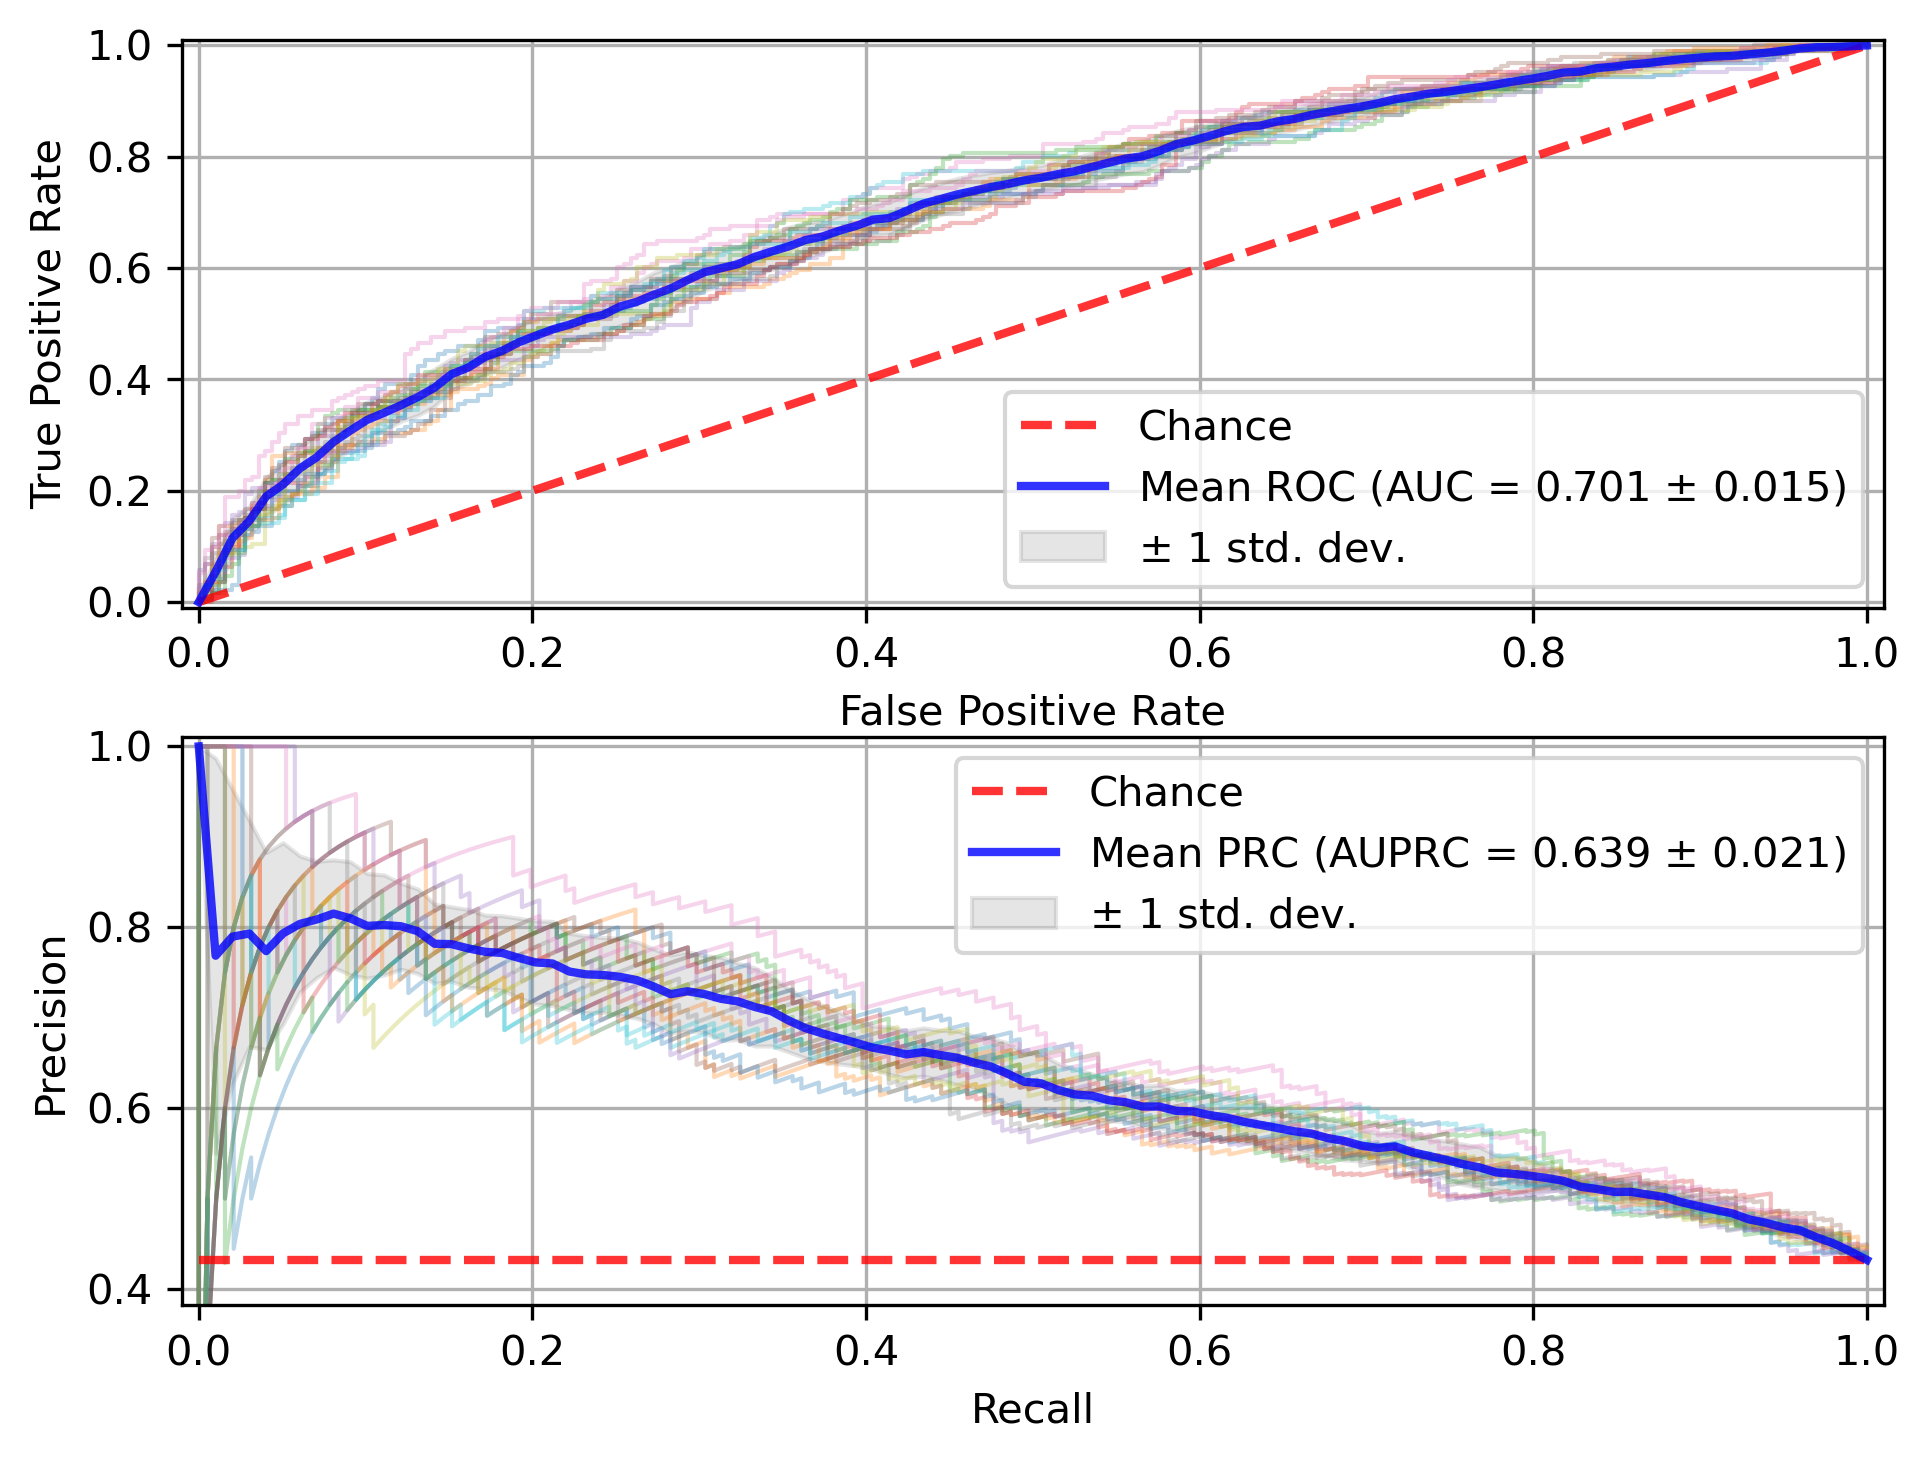

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=1, dpi=300#,figsize=(15, 15)
                      )
fig.tight_layout()
ax1, ax2 = ax.flatten()
param_grid = [{'max_depth': [None,3,5],
               'colsample_bytree': [0.1,0.2,0.3,0.4, 0.5,0.6,0.7,0.8,0.9],
               'n_estimators': np.arange(50,300,50)
              }]

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

precision_array = []
mean_recall_array = np.linspace(0, 1, 100)
aucs_pr=[]

acc_xgb=list()
prec_xgb=list()
f1_xgb=list()


for i, CV_repeat in enumerate(range(CV_repeats)): #-#-#
    #Verbose 
    print('\n------------ CV Repeat number:', CV_repeat)
    #Establish CV scheme
    CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_states[i]) # Set random state 

    ix_training, ix_test = [], []
    # Loop through each fold and append the training & test indices to the empty lists above
    for fold in CV.split(X,y):
        ix_training.append(fold[0]), ix_test.append(fold[1])
    
    predicted=[]
    label=[]
    score=[]
    
    ## Loop through each outer fold and extract SHAP values 
    for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)): 
        #Verbose
        print('\n------ Fold Number:',i)
        X_train, X_test = X.iloc[train_outer_ix, :], X.iloc[test_outer_ix, :]
        index_train, index_test=X_train.index, X_test.index
        y_train, y_test = y[train_outer_ix], y[test_outer_ix]

        ## Establish inner CV for parameter optimization #-#-#
        cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1) #-#-#
        
        # Search to optimize hyperparameters
        model = XGBClassifier(eval_metric='logloss',seed=0,importance_type='total_gain')
        search = RandomizedSearchCV(model, param_grid, scoring='roc_auc', cv=cv_inner, refit=True,random_state=0) #-#-#
        result = search.fit(X_train, y_train) #-#=#
        
        best_model=result.best_estimator_
        
        # Fit model on training data 
        best_model.fit(X_train, y_train) #-#-#
                
        yhat = best_model.predict(X_test)
        
        y_score = best_model.predict_proba(X_test)[:, 1]
        
        label.append(y_test)
        
        predicted.append(yhat)
        score.append(y_score)
        
            
    acc_sc=accuracy_score(np.hstack(label), np.hstack(predicted))
    acc_xgb.append(acc_sc)
    #print('Accuracy:',round(acc,4))
    
    prec_sc=precision_score(np.hstack(label), np.hstack(predicted),pos_label=1)
    prec_xgb.append(prec_sc)
    #print('Precision:',round(prec,4))

   
    f1_sc=f1_score(np.hstack(label), np.hstack(predicted))
    f1_xgb.append(f1_sc)
    
   
    #ROC
    fpr, tpr, threshold= roc_curve(np.hstack(label), np.hstack(score))
    tprs.append(np.interp(mean_fpr,fpr,tpr))
    tprs[-1][0]=0.0
    roc_auc=metrics.auc(fpr,tpr)
    aucs.append(roc_auc)
    ax1.plot(fpr, tpr, lw=1, alpha=0.3)
    
    #PR
    precision_fold, recall_fold, _ = precision_recall_curve(np.hstack(label), np.hstack(score))
    precision_fold, recall_fold = precision_fold[::-1], recall_fold[::-1]  # reverse order of results
    prec_array = np.interp(mean_recall_array, recall_fold, precision_fold)
    precision_array.append(prec_array)
    precision_array[-1][0]=1
    pr_auc = metrics.auc(recall_fold, precision_fold)
    aucs_pr.append(pr_auc)
    
    ax2.plot(recall_fold, precision_fold, alpha=0.3, lw=1)
            

ax1.plot([0,1], [0,1], linestyle='--', lw=2,color='r', label='Chance',alpha=0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax1.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])
ax1.set_xlabel('False Positive Rate'#,fontsize=20
              )
ax1.set_ylabel('True Positive Rate'#,fontsize=20
              )
#plt.xticks(fontsize=18)
#plt.yticks(fontsize=18)
#plt.title('Repeated Cross-Validation ROC',fontsize=18)
ax1.legend(loc="lower right"
           #,bbox_to_anchor=(1.65, 0.01)
           #, prop={'size': 22}
          )

ax1.grid()

# plot the precision-recall curves
no_skill = len((np.hstack(label))[(np.hstack(label))==1]) / len((np.hstack(label)))
ax2.plot([0, 1], [no_skill, no_skill], linestyle='--',lw=2, label='Chance',alpha=0.8,color='r')
mean_precision_array=np.mean(precision_array, axis=0)
#mean_precision_array[-1]=1.0
mean_auc_pr=metrics.auc(mean_recall_array,mean_precision_array)
std_auc_pr=np.std(aucs_pr)
ax2.plot(mean_recall_array,mean_precision_array, color='b',
         label=r'Mean PRC (AUPRC = %0.3f $\pm$ %0.3f)' %(mean_auc_pr, std_auc_pr),
         lw=2,alpha=0.8)

std_precision_array=np.std(precision_array, axis=0)
precision_array_upper=np.minimum(mean_precision_array+std_precision_array,1)
precision_array_lower=np.maximum(mean_precision_array-std_precision_array,0)
ax2.fill_between(mean_recall_array,precision_array_lower,precision_array_upper,color='grey',
         alpha=0.2,label=r'$\pm$ 1 std. dev. ')

ax2.set_xlim([-0.01,1.01])
ax2.set_ylim([no_skill-0.05,1.01])
ax2.set_xlabel('Recall'#, fontsize=18
              )
ax2.set_ylabel('Precision'#,fontsize=18
              )
#ax2.set_xticks([18])
#ax2.set_yticks([18])

ax2.legend(loc='upper right')

ax2.grid()

plt.show()    

In [9]:
print('ACC: %.3f (%.3f)' % (mean(acc_xgb), std(acc_xgb)))
print('Precision: %.3f (%.3f)' % (mean(prec_xgb), std(prec_xgb)))
print('AuROC: %.3f (%.3f)' % (mean_auc, std_auc))
print('F1: %.3f (%.3f)' % (mean(f1_xgb), std(f1_xgb)))
print('AuPRC: %.3f (%.3f)' % (mean_auc_pr, std_auc_pr))

ACC: 0.652 (0.017)
Precision: 0.613 (0.022)
AuROC: 0.701 (0.015)
F1: 0.567 (0.022)
AuPRC: 0.639 (0.021)
